In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [5]:
Base.classes.keys()

['measurement', 'station']

In [6]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
session = Session(engine)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """


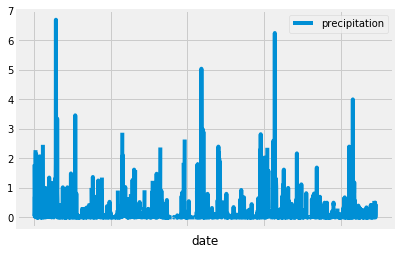

In [9]:
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year).all()
clmt_analysis = pd.DataFrame(results, columns=['date','precipitation'])
clmt_analysis.set_index(clmt_analysis['date'], inplace=True)
clmt_analysis = clmt_analysis.sort_values("date")
clmt_analysis.plot(x_compat=True)

In [10]:
clmt_analysis.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
#Stations Available?
session.query(func.count(Station.station)).all()

[(9)]

In [12]:
#Most Active Stations?
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
#Lowest Temp Recorded, Highest Temp Recorded and Avg Temp at Most active Station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

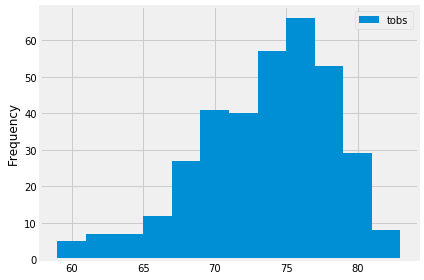

In [16]:
# Highest number of temp observations...Query the last 12 months of temp observation data
from pandas.plotting import table
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= last_year).all()
clmt_analysis = pd.DataFrame(results, columns=['tobs'])
clmt_analysis.plot.hist(bins=12)
plt.tight_layout()

In [18]:
#Min, Avg and Max temps for the range of dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2011-11-10', '2011-11-17'))

[(65.0, 72.71186440677967, 79.0)]


In [22]:
last_year_start = dt.date(2010, 11, 10) - dt.timedelta(days=365)
last_year_end = dt.date(2011, 11, 17) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(last_year_start.strftime("%Y-%m-%d"), last_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

56.0 72.74193548387096 87.0


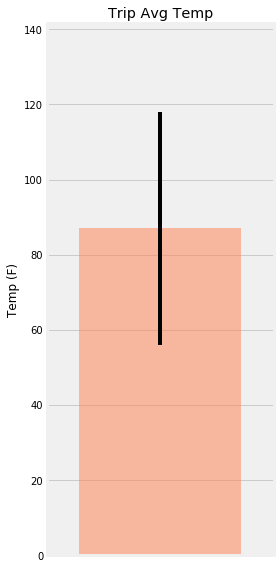

In [23]:
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
fig.tight_layout()
fig.show()

In [24]:
start_date = '2011-11-10'
end_date = '2011-11-17'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 2.7699999999999996), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.29000000000000004), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.16999999999999998), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.12000000000000001), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.12), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.1), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.09), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.05)]
